In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib import gridspec

from copy import copy
from matplotlib.colors import LogNorm

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

### Load Processed Data

In [2]:
#Data Unfolded From Django
cuts      = np.load('cuts.npy')
jet_pT    = np.load('jet_pT.npy')
q_perp    = np.load('q_perp.npy')
asymm_phi = np.load('asymm_angle.npy')
weights   = np.load('weights.npy')
mc_weights = np.load("mc_weights.npy")
nn_weights = np.load("nn_weights.npy")

In [3]:
#Data Unfolded From Rapgap
cuts_h1rpgp      = np.load('from_rapgap_cuts.npy')
jet_pT_h1rpgp    = np.load('from_rapgap_jet_pT.npy')[cuts_h1rpgp]
q_perp_h1rpgp    = np.load('from_rapgap_q_perp.npy')[cuts_h1rpgp]
asymm_phi_h1rpgp = np.load('from_rapgap_asymm_angle.npy')[cuts_h1rpgp]
weights_h1rpgp   = np.load('from_rapgap_weights.npy')[cuts_h1rpgp]
mc_weights_h1rpgp = np.load("from_rapgap_mc_weights.npy")[cuts_h1rpgp]
nn_weights_h1rpgp = np.load("from_rapgap_nn_weights.npy")[cuts_h1rpgp]

### Load Django

In [4]:
rapgap_cuts      = np.load('rapgap_cuts.npy')
rapgap_jet_pT    = np.load('rapgap_jet_pT.npy')[rapgap_cuts]
rapgap_q_perp    = np.load('rapgap_q_perp.npy')[rapgap_cuts]
rapgap_asymm_phi = np.load('rapgap_asymm_angle.npy')[rapgap_cuts]
rapgap_weights   = np.load('rapgap_weights.npy')[rapgap_cuts]

### Load Raw Data for Bootstrapping Error Bars

In [52]:
raw_cuts = np.load("dataRaw_cuts.npy")
raw_q_perp = np.load("dataRaw_q_perp.npy")

cut_on_raw=True
if cut_on_raw:
    raw_q_perp=raw_q_perp[raw_cuts]

### Apply Cuts

In [5]:
if (len(q_perp) == len(cuts)):
    jet_pT    = jet_pT[cuts]
    q_perp    = q_perp[cuts]
    asymm_phi = asymm_phi[cuts]
    weights   = weights[cuts]
    mc_weights = mc_weights[cuts]
    nn_weights = nn_weights[cuts]
    print("%i / %i Events Remain"%(len(q_perp),len(cuts)))

else:
    print("Cuts already applied!")
    

7234481 / 57882501 Events Remain


___

## Calculate Bin Average $\cos(\phi), \cos(2\phi)$, and $\cos(3\phi)$ in Bins of $q_\perp$

### Dictionaryies and Binning

In [23]:
#Make Dictionaries and Binning
N_Bins = 50
q_max = 10.00
q_perp_bins = np.linspace(0,q_max,N_Bins+1)
digits = np.digitize(q_perp,q_perp_bins)-1
keys=["q_perp","cos1","cos2","cos3"]

h1_of = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

django = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

rapgap = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

h1_rpgp = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

In [47]:
def get_bootsrap_errors(N_Bootstraps,N_Bins,Binning,Observable):
    
    boot_ensemble = np.random.poisson(1,(N_Bootstraps,len(Observable)))
    bin_wsums = np.zeros((N_Bootstraps,N_Bins))
    for istrap in range(N_Bootstraps):
        #need q_perp_data_raw
        b,edges = np.histogram(Observable,weights=boot_ensemble[istrap],bins=Binning) #weighted sums in each bin
        bin_wsums[istrap]=b  #row = bootstrap iteration, column = bin number

    bin_wsums = bin_wsums.T #row = bin number, column = boostrap iter
    btsrp_errors = np.zeros(N_Bins)
    for ibin in range(N_Bins):
        btsrp_errors[ibin] = np.std(bin_wsums[ibin])/np.mean(bin_wsums[ibin])
        
    return(btsrp_errors)
    

In [53]:
#%%capture
btstrp_errors = get_bootsrap_errors(1000,N_Bins,q_perp_bins,raw_q_perp)

In [54]:
print(btstrp_errors)

[0.0387209  0.02194438 0.01718584 0.01542742 0.0138512  0.01356343
 0.0118981  0.01259519 0.01267507 0.01246001 0.01214845 0.01298389
 0.01305131 0.01311177 0.01398648 0.01400875 0.01543411 0.0164191
 0.01824279 0.02028654 0.02274664 0.02463503 0.0272701  0.03077547
 0.03167922 0.03345786 0.03768986 0.03933001 0.04574554 0.04774851
 0.05749491 0.05711142 0.05531911 0.06547364 0.06686182 0.07327634
 0.07559737 0.08036408 0.08561679 0.09502805 0.09715755 0.10963637
 0.10128132 0.12030434 0.13594963 0.14672811 0.1278208  0.15074633
 0.20052931 0.16765602]


In [10]:
def averages_in_qperp_bins(dic, N_Bins,q_perp,asymm_phi,weights,q_max=10):
    
    q_perp_bins = np.linspace(0,q_max,N_Bins+1)
    digits = np.digitize(q_perp,q_perp_bins)-1
    
    q_w = q_perp*weights
    cos1_w = np.cos(1*asymm_phi)*weights
    cos2_w = np.cos(2*asymm_phi)*weights
    cos3_w = np.cos(3*asymm_phi)*weights
    
    for i in range(N_Bins):
        bin_mask = digits==i
        bin_wsum = np.sum(weights[bin_mask])
        
        dic["q_perp"][i]  = np.nansum(q_w[bin_mask])/bin_wsum
        dic["cos1"][i] = np.nansum(cos1_w[bin_mask])/bin_wsum
        dic["cos2"][i] = np.nansum(cos2_w[bin_mask])/bin_wsum
        dic["cos3"][i] = np.nansum(cos3_w[bin_mask])/bin_wsum
        dic["errors"][i] = 1/np.sqrt(np.nansum(bin_wsum))
    return

In [56]:
h1_of = dict(zip(
["q_perp","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins)]))

averages_in_qperp_bins(h1_of, N_Bins, q_perp, asymm_phi,weights)
naive_errors = h1_of["errors"]
h1_of["errors"] = btstrp_errors
#plt.hist(h1_of["cos1"],alpha=0.5)

In [57]:
#[Django]
q_w = q_perp*mc_weights
cos1_dj = np.cos(1*asymm_phi)*mc_weights
cos2_dj = np.cos(2*asymm_phi)*mc_weights
cos3_dj = np.cos(3*asymm_phi)*mc_weights
for i in range(N_Bins):
    
    bin_mask = digits==i
    bin_sum = np.sum(mc_weights[bin_mask])
    
    
    django["q_perp"][i]= np.sum(q_w[bin_mask])/bin_sum
    django["cos1"][i] = np.sum(cos1_dj[bin_mask])/bin_sum
    django["cos2"][i] = np.sum(cos2_dj[bin_mask])/bin_sum
    django["cos3"][i] = np.sum(cos3_dj[bin_mask])/bin_sum

In [58]:
#Data unfolded USING Rapgap
h1_rpgp = dict(zip(
["q_perp","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins)]))
averages_in_qperp_bins(h1_rpgp, N_Bins, q_perp_h1rpgp, asymm_phi_h1rpgp,weights_h1rpgp)

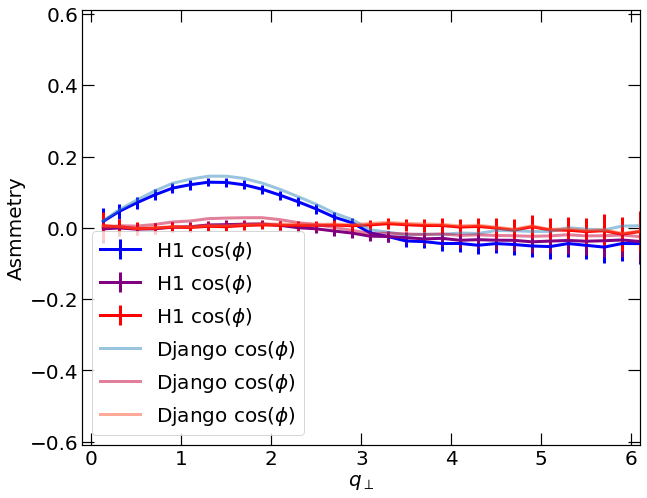

In [59]:
fig = plt.figure(figsize=(10,8))
colors=["blue","purple","red"]
for i,key in enumerate(keys[1:]):
    plt.errorbar(h1_of["q_perp"],h1_of[key],yerr=btstrp_errors,label="H1 $\cos(\phi)$",color=colors[i],linewidth=3)

for i,key in enumerate(keys[1:]):
    plt.errorbar(django["q_perp"],django[key],label="Django $\cos(\phi)$",alpha=0.5,linewidth=3)

plt.xlim(-0.1,6.1)
plt.ylim(-.61,.61)
plt.legend(fontsize=20)
plt.xlabel("$q_\perp$",fontsize=20)
plt.ylabel("Asmmetry",fontsize=20)
plt.savefig("unfolded_separately.pdf")

___

In [60]:
#Rapgap
digits = np.digitize(rapgap_q_perp,q_perp_bins)-1
q_w = rapgap_q_perp*rapgap_weights
cos1_rp = np.cos(1*rapgap_asymm_phi)*rapgap_weights
cos2_rp = np.cos(2*rapgap_asymm_phi)*rapgap_weights  
cos3_rp = np.cos(3*rapgap_asymm_phi)*rapgap_weights
for i in range(N_Bins):
    
    bin_mask = digits==i
    bin_sum = np.sum(rapgap_weights[bin_mask])

    rapgap["q_perp"][i]= np.nansum(q_w[bin_mask])/bin_sum
    rapgap["cos1"][i] = np.nansum(cos1_rp[bin_mask])/bin_sum
    rapgap["cos2"][i] = np.nansum(cos2_rp[bin_mask])/bin_sum
    rapgap["cos3"][i] = np.nansum(cos3_rp[bin_mask])/bin_sum

## Theory https://arxiv.org/pdf/2106.05307.pdf

In [61]:
theory = {}

for i in range(1,4):
    key = "cos%i"%(i)
    theory[key] = np.load("theory_cos%iphi.npy"%(i))
    key = key+"_x"
    theory[key] = np.load("theory_cos%iphi_x.npy"%(i))

## Pythia [Roli+Kyle]

In [62]:
pythia = {}

for i in range(1,4):
    key = "cos%i"%(i)
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,1]
    key = key+"_x"
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,0]

___

## Overlay Everything

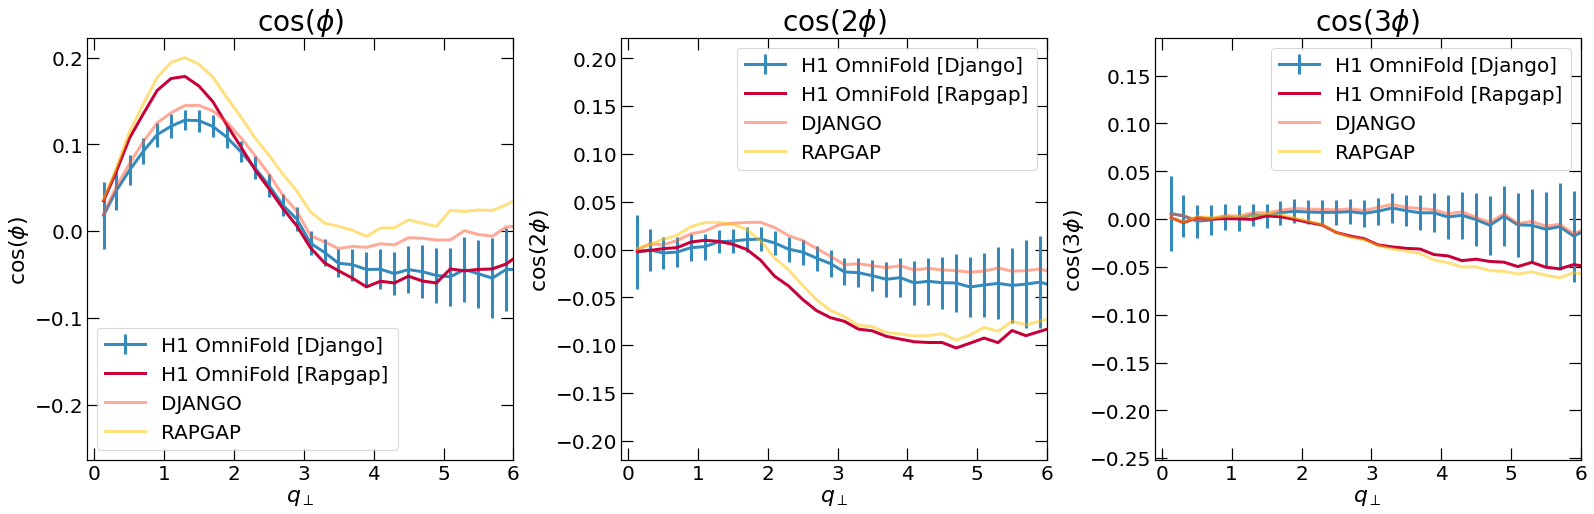

In [63]:
plot_data = True
plot_theory = False
plot_pythia = False
plot_django = True
plot_rapgap = True
plot_h1rpgp = True

#fig = plt.figure(figsize=(10,8))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7), constrained_layout=True)

if (plot_data):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(h1_of["q_perp"],h1_of[key],yerr=btstrp_errors,label="H1 OmniFold [Django] ",linewidth=3)
        
if (plot_h1rpgp):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(h1_rpgp["q_perp"],h1_rpgp[key],label="H1 OmniFold [Rapgap]",linewidth=3)
        
if (plot_django):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(django["q_perp"],django[key],label="DJANGO",linewidth=3,alpha=0.5)
        
if (plot_rapgap):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(rapgap["q_perp"],rapgap[key],label="RAPGAP",linewidth=3,alpha=0.5)


if (plot_theory):
    axes[0].plot(theory['cos1_x'],theory['cos1'],label="Theory [$\cos\phi$]",linewidth=4,linestyle="solid",color="blue")
    axes[1].plot(theory['cos2_x'],theory['cos2'],label="Theory [$\cos2\phi$]",linewidth=4,linestyle="solid",color="purple")
    axes[2].plot(theory['cos3_x'],theory['cos3'],label="Theory [$\cos3\phi$]",linewidth=4,linestyle="solid",color="red")
    
if (plot_pythia):
    axes[0].plot(pythia['cos1_x'],pythia['cos1'],label="Pythia [$\cos\phi$]",linewidth=4,linestyle="dashed",color="blue")
    axes[1].plot(pythia['cos2_x'],pythia['cos2'],label="Pythia [$\cos2\phi$]",linewidth=4,linestyle="dashed",color="purple")
    axes[2].plot(pythia['cos3_x'],pythia['cos3'],label="Pythia [$\cos3\phi$]",linewidth=4,linestyle="dashed",color="red")

#plt.xlim(-0.1,6.1)
#plt.ylim(-1.61,0.61)
for i in range(3):
    string = r"$\cos(%i\phi)$"%(i+1)
    if i ==0:
        string = r"$\cos(\phi)$"
        
    axes[i].legend()
    axes[i].set_title(string)
    #axes[i].set_ylim(-0.15,0.3)
    axes[i].set_xlim(-0.1,6.0)
    axes[i].set_ylabel(string)
    axes[i].set_xlabel(r"$q_\perp$")


string = ""
theory_string = ""
pythia_sttring = ""
if (plot_data):
        string = "Unfolded H1, "
        
if (plot_django):
        string += "Django, "

if (plot_theory and plot_pythia):
    string += " Theory, and Pythia"

elif (plot_theory):
    string += "and Theory"

elif (plot_pythia):
    string += "and Pythia"
    
    
plt.savefig(string+".pdf")

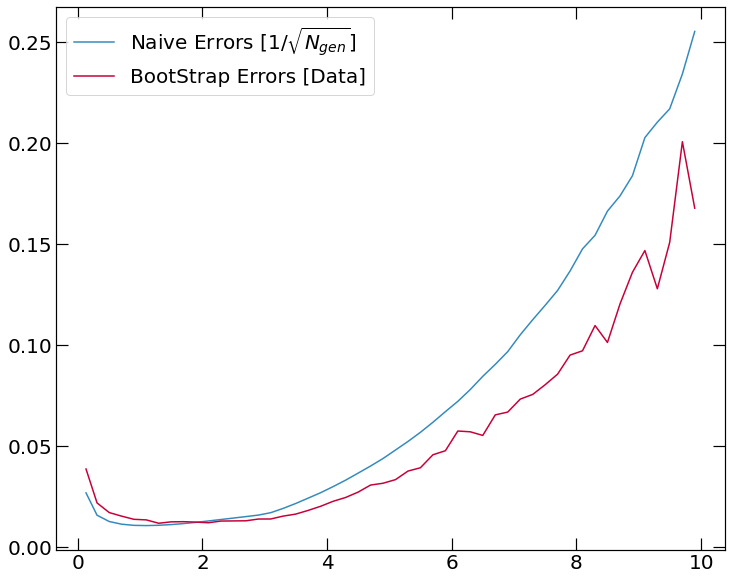

In [64]:
plt.plot(h1_of["q_perp"],naive_errors,label=r"Naive Errors $[1/\sqrt{N_{gen}}]$")
plt.plot(h1_of["q_perp"],btstrp_errors,label="BootStrap Errors [Data]")
plt.legend()

### 2D Asymmetry Histograms

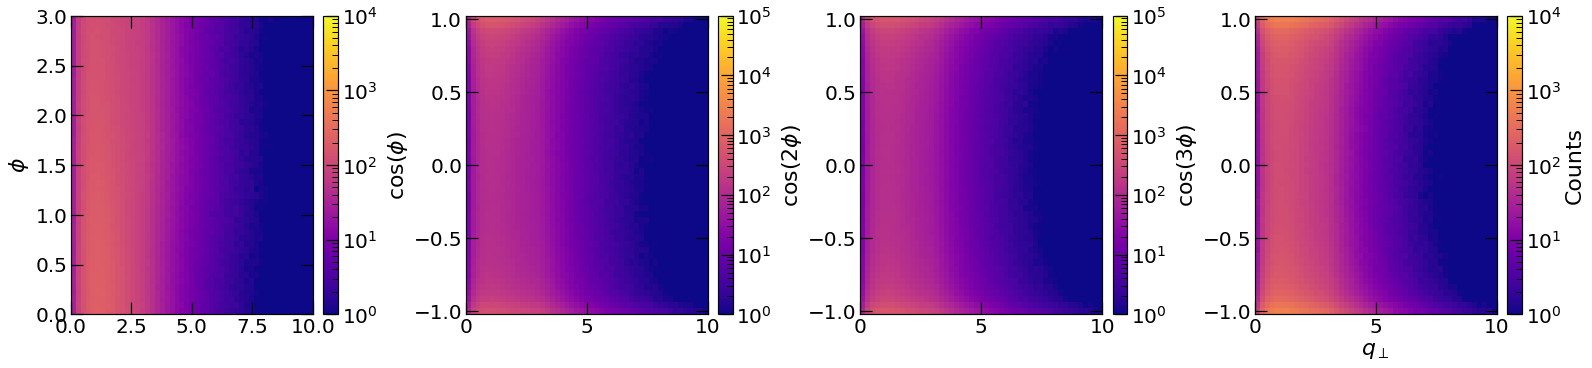

In [90]:
N_Bins = 50
xbins = np.linspace(-0.01,10.01,N_Bins)
ybins = np.linspace(-1.02,1.02,N_Bins)
cmap = copy(plt.cm.plasma)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5), constrained_layout=True)


h0, xedges0, yedges0 = np.histogram2d(q_perp, (asymm_phi), bins=(np.linspace(0,10,N_Bins),np.linspace(0,3,N_Bins)), weights=weights)
h1, xedges1, yedges1 = np.histogram2d(q_perp, np.cos(asymm_phi),bins=(xbins,ybins), weights=weights)
h2, xedges2, yedges2 = np.histogram2d(q_perp, np.cos(2*asymm_phi), bins=(xbins,ybins), weights=weights)
h3, xedges3, yedges3 = np.histogram2d(q_perp, np.cos(3*asymm_phi), bins=(xbins,ybins), weights=weights)

pcm0 = axes[0].pcolormesh(xedges0, yedges0, h0.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e4), rasterized=True)
pcm1 = axes[1].pcolormesh(xedges1, yedges1, h1.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm2 = axes[2].pcolormesh(xedges2, yedges2, h2.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm3 = axes[3].pcolormesh(xedges3, yedges3, h3.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e4), rasterized=True)
axes[0].set_ylabel("$\phi$",fontsize=22)
axes[1].set_ylabel("$\cos(\phi)$",fontsize=22)
axes[2].set_ylabel("$\cos(2\phi)$",fontsize=22)
axes[3].set_ylabel("$\cos(3\phi)$",fontsize=22)
#cb0=axes[0].colorbar(pcm,ax)

fig.colorbar(pcm0, ax=axes[0], pad= -0.049)
fig.colorbar(pcm1, ax=axes[1], pad= -0.01)
fig.colorbar(pcm2, ax=axes[2], pad= -0.01)
cb=fig.colorbar(pcm3, ax=axes[3], pad= -0.01)

plt.xlabel("$q_\perp$",fontsize=22)
cb.set_label("Counts",fontsize=22)
plt.savefig("2D_asymmetries.png")